## 1. Load and Prepare Patient Data

In [6]:

import os
import pandas as pd

# Load 100 patient files from each dataset
def load_patients(path):
    files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.psv')]
    patient_data = {}
    for file_path in files:
        pid = os.path.basename(file_path).split(".")[0]
        df = pd.read_csv(file_path, sep='|')
        patient_data[pid] = df
    return patient_data

patients_A = load_patients('training_setA')
patients_B = load_patients('training_setB')

patient_dict = {**patients_A, **patients_B}
print(f"Loaded {len(patient_dict)} patients")


Loaded 40336 patients


## 2. Apply MICE Imputation using `encode_dict_deltas`

In [7]:

import sys
from importlib.machinery import SourceFileLoader

mice_path = 'pipelines_le/mgbm_pipeline/src/models/mice/encode_data.py'
encode_data_module = SourceFileLoader("encode_data", mice_path).load_module()
encode_dict_deltas = encode_data_module.encode_dict_deltas

encoded_dict = encode_dict_deltas(patient_dict)
df = pd.concat(encoded_dict.values(), ignore_index=True)
df.head()


Encoding patients: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40336/40336 [28:38<00:00, 23.48it/s]


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hgb_delta1,Hgb_delta2,PTT_delta1,PTT_delta2,WBC_delta1,WBC_delta2,Fibrinogen_delta1,Fibrinogen_delta2,Platelets_delta1,Platelets_delta2
0,80.0,100.0,36.50,121.00,58.0,41.00,13.5,NaN,1.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,76.0,100.0,36.25,113.25,61.0,41.50,12.0,NaN,1.0,25.0,...,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0
2,80.0,100.0,36.25,132.75,71.5,46.25,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78.0,100.0,36.10,103.50,58.0,43.00,12.0,NaN,-3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,74.0,100.0,36.00,128.75,69.5,44.50,12.5,NaN,-3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Select Features and Impute Remaining Missing Values

In [10]:

from sklearn.impute import SimpleImputer

# Keep columns with less than 20% missing values
missing_ratios = df.isnull().mean()
valid_features = missing_ratios[missing_ratios < 0.8].index.tolist()

# Drop unwanted columns
for col in ['SepsisLabel', 'SepsisLabel_delta', 'patient_id']:
    if col in valid_features:
        valid_features.remove(col)

X = df[valid_features]
y = df['SepsisLabel']

# Impute remaining missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


## 4. Train Random Forest Classifier

In [15]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# 1. Stratified split of ALL patients into train/test
all_patient_labels = df.groupby("patient_id")["SepsisLabel"].max()
all_train_pids, test_pids = train_test_split(
    all_patient_labels.index, test_size=0.2, random_state=42, stratify=all_patient_labels
)

# 2. From training set, balance sepsis and non-sepsis patients
train_labels = all_patient_labels.loc[all_train_pids]
sepsis_train = train_labels[train_labels == 1].index
non_sepsis_train = train_labels[train_labels == 0].sample(n=len(sepsis_train), random_state=42)
balanced_train_pids = sepsis_train.union(non_sepsis_train)

# 3. Mask the full dataset
train_mask = df['patient_id'].isin(balanced_train_pids)
test_mask = df['patient_id'].isin(test_pids)

X_train = X_imputed[train_mask]
y_train = y[train_mask]
X_test = X_imputed[test_mask]
y_test = y[test_mask]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 5. Evaluate Model Performance

In [16]:

from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    306061
           1       0.05      0.03      0.03      5553

    accuracy                           0.97    311614
   macro avg       0.52      0.51      0.51    311614
weighted avg       0.97      0.97      0.97    311614

ROC AUC Score: 0.5999


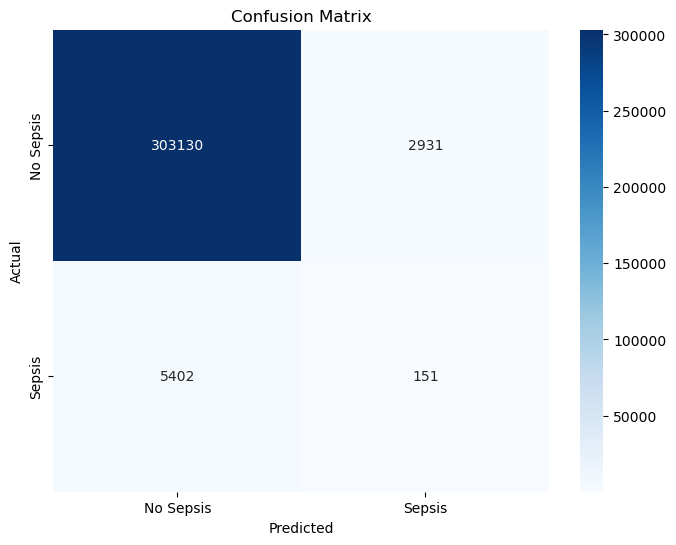

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()